<a href="https://colab.research.google.com/github/Guru2308/PR-CIA/blob/main/BCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BCI - Brain Computer Interface
A brain–computer interface is a direct communication pathway between the brain's electrical activity and an external device

#EEG - Electroencephalogram
- ﻿USED TO MEASURE ELECTRICAL ACTIVITY OF THE BRAIN in cerebral cortex

- ﻿DETECTS ACTIVITY OF LARGE GROUPS OF NEURONS THAT ARE ACTIVE AT THE SAME TIME

- ﻿PRIMARILY MEASURES POSTSYNAPTIC POTENTIALS (NOT ACTION POTENTIALS)


#Cons:
 ﻿LIMITED ABILITY TO ACCURATELY RECORD FROM STRUCTURES DEEPER THAN THE CORTEX

#G-DRIVE Mount


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#IMPORTS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
import os
import random
import time
from keras.layers import LeakyReLU

(250, 16, 60)


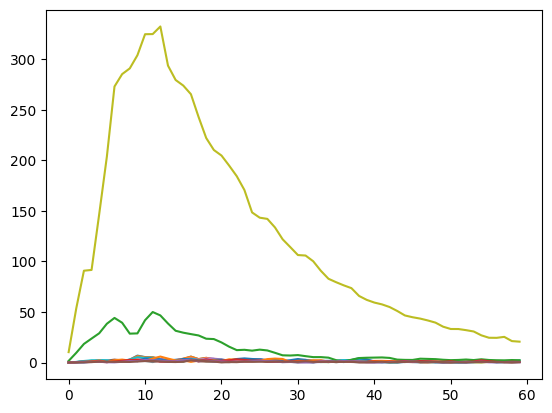

In [3]:
d = np.load("/content/gdrive/MyDrive/model_data/data/left/1572878065.npy")
print(d.shape)
for channel in d[0]:
    plt.plot(channel)
img = plt.show()
img

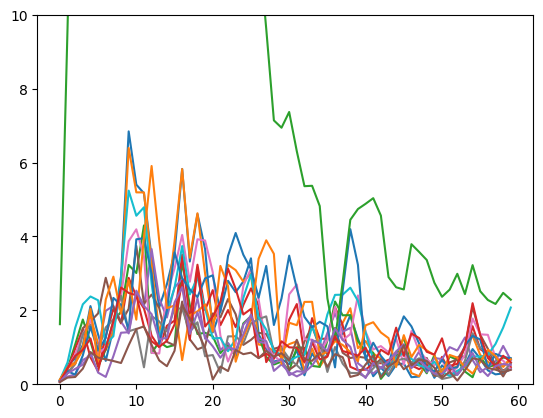

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load the numpy data
d = np.load("/content/gdrive/MyDrive/model_data/data/left/1572878065.npy")

# Plot the data
for channel in d[0]:
    plt.plot(channel)

# Set y-axis limits
plt.ylim(0, 10)

# Show the image
plt.show()

(250, 16, 60)


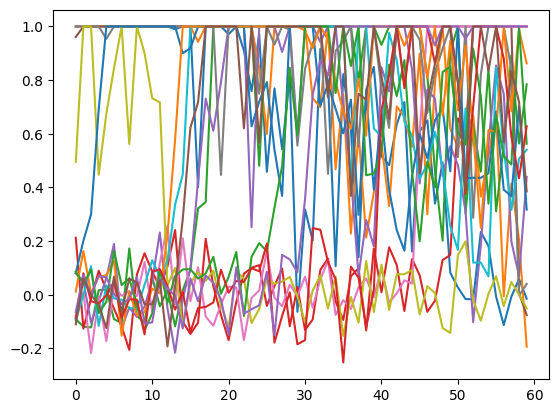

In [5]:
d = np.load("/content/gdrive/MyDrive/model_data/aug_data/left/augmented_1573403596.npy")
print(d.shape)
for channel in d[0]:
    plt.plot(channel)
plt.show()

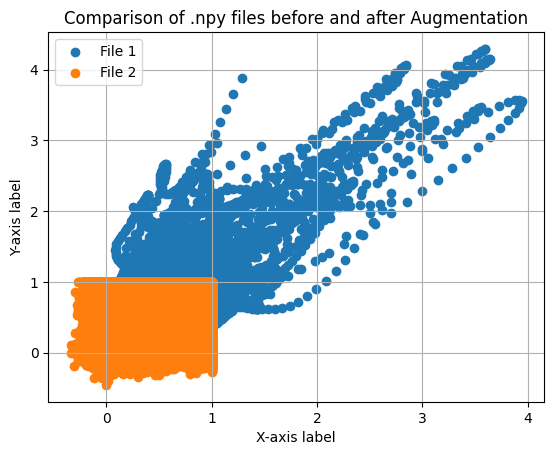

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def load_npy_file(file_path):
    try:
        data = np.load(file_path)
        return data
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"Error loading '{file_path}': {e}")
        return None

def visualize_comparison(file1_path, file2_path):
    # Load data from the .npy files
    data1 = load_npy_file(file1_path)
    data2 = load_npy_file(file2_path)

    if data1 is None or data2 is None:
        return

    # Add your specific visualization code here, depending on the data format in your .npy files.
    # For example, you can use Matplotlib to create plots to compare the data.

    # Example: Scatter plot
    plt.scatter(data1[:, 0], data1[:, 1], label='File 1')
    plt.scatter(data2[:, 0], data2[:, 1], label='File 2')

    plt.xlabel('X-axis label')
    plt.ylabel('Y-axis label')
    plt.title('Comparison of .npy files before and after Augmentation')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Replace 'file1.npy' and 'file2.npy' with the paths of your .npy files
    file1_path = '/content/gdrive/MyDrive/model_data/data/left/1572814991.npy'
    file2_path = '/content/gdrive/MyDrive/model_data/aug_data/left/augmented_1572814991.npy'

    visualize_comparison(file1_path, file2_path)

#TRAINING

In [7]:
ACTIONS = ["left", "right", "none"]
reshape = (-1, 16, 60)

In [8]:
def create_data(starting_dir="/content/gdrive/MyDrive/model_data/data"):
    training_data = {}
    for action in ACTIONS:
        if action not in training_data:
            training_data[action] = []

        data_dir = os.path.join(starting_dir,action)
        for item in os.listdir(data_dir):
            #print(action, item)
            data = np.load(os.path.join(data_dir, item))
            for item in data:
                training_data[action].append(item)

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)

    for action in ACTIONS:
        np.random.shuffle(training_data[action])  # note that regular shuffle is GOOF af
        training_data[action] = training_data[action][:min(lengths)]

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)
    # creating X, y
    combined_data = []
    for action in ACTIONS:
        for data in training_data[action]:

            if action == "left":
                combined_data.append([data, [1, 0, 0]])

            elif action == "right":
                #np.append(combined_data, np.array([data, [1, 0]]))
                combined_data.append([data, [0, 0, 1]])

            elif action == "none":
                combined_data.append([data, [0, 1, 0]])

    np.random.shuffle(combined_data)
    print("length:",len(combined_data))
    return combined_data

Creating training data

In [9]:
print("creating training data")
traindata = create_data(starting_dir="/content/gdrive/MyDrive/model_data/data")
train_X = []
train_y = []
for X, y in traindata:
    train_X.append(X)
    train_y.append(y)

creating training data
[95125, 94125, 95375]
[94125, 94125, 94125]
length: 282375


Creating testing data

In [10]:
print("creating testing data")
testdata = create_data(starting_dir="/content/gdrive/MyDrive/model_data/validation_data")
test_X = []
test_y = []
for X, y in testdata:
    test_X.append(X)
    test_y.append(y)

creating testing data
[11750, 11750, 11750]
[11750, 11750, 11750]
length: 35250


In [11]:
print(len(train_X))
print(len(test_X))

282375
35250


In [12]:
print(np.array(train_X).shape)
train_X = np.array(train_X).reshape(reshape)
test_X = np.array(test_X).reshape(reshape)

(282375, 16, 60)


In [13]:
train_X = np.clip(np.array(train_X).reshape(reshape), -10, 10) / 10
test_X = np.clip(np.array(test_X).reshape(reshape), -10, 10) / 10

In [14]:
train_y = np.array(train_y)
test_y = np.array(test_y)

In [15]:
train_X[3].shape

(16, 60)

#BUILDING A MODEL

In [16]:
model = Sequential()

model.add(Conv1D(64, (3), input_shape=train_X.shape[1:]))
model.add(Activation('relu'))

model.add(Conv1D(128, (2)))
model.add(Activation('relu'))

model.add(Conv1D(128, (2)))
model.add(Activation('relu'))

model.add(Conv1D(64, (2)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(64, (2)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Flatten())

model.add(Dense(512))
model.add(Dense(256))
model.add(Dense(128))

model.add(Dense(3))
model.add(Activation('softmax'))

#COMPILING A MODEL

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Fitting the model

In [18]:
model.fit(train_X, train_y, batch_size=64, epochs=1, validation_data=(test_X, test_y))

4413/4413 [==============================] - 45s 7ms/step - loss: 0.7090 - accuracy: 0.6562 - val_loss: 2.0141 - val_accuracy: 0.4050


#MODEL EVALUATION

In [19]:
accuracy = model.evaluate(test_X, test_y, batch_size=32)

1102/1102 [==============================] - 7s 6ms/step - loss: 2.0141 - accuracy: 0.4050


In [20]:
accuracy

[2.0140750408172607, 0.4050496518611908]

In [21]:
model.save('bci.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#TESTING AND MAKING DATA


IMPORTS


In [22]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
MODEL_NAME = "/content/bci.h5"

In [24]:
CLIP = True
CLIP_VAL = 10



Loading the model

In [25]:
model = tf.keras.models.load_model(MODEL_NAME)

In [26]:
VALDIR = '/content/gdrive/MyDrive/model_data/validation_data'
ACTIONS = ['left','none','right']
PRED_BATCH = 32

In [27]:
def get_val_data(valdir, action, batch_size):

    argmax_dict = {0: 0, 1: 0, 2: 0}
    raw_pred_dict = {0: 0, 1: 0, 2: 0}

    action_dir = os.path.join(valdir, action)
    for session_file in os.listdir(action_dir):
        filepath = os.path.join(action_dir,session_file)
        if CLIP:
            data = np.clip(np.load(filepath), -CLIP_VAL, CLIP_VAL) / CLIP_VAL
        else:
            data = np.load(filepath)

        preds = model.predict([data.reshape(-1, 16, 60)], batch_size=batch_size)

        for pred in preds:
            argmax = np.argmax(pred)
            argmax_dict[argmax] += 1
            for idx,value in enumerate(pred):
                raw_pred_dict[idx] += value

    argmax_pct_dict = {}

    for i in argmax_dict:
        total = 0
        correct = argmax_dict[i]
        for ii in argmax_dict:
            total += argmax_dict[ii]

        argmax_pct_dict[i] = round(correct/total, 3)

    return argmax_dict, raw_pred_dict, argmax_pct_dict

In [28]:
def make_conf_mat(left, none, right):

    action_dict = {"left": left, "none": none, "right": right}
    action_conf_mat = pd.DataFrame(action_dict)
    actions = [i for i in action_dict]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(action_conf_mat, cmap=plt.cm.RdYlGn)
    ax.set_xticklabels([""]+actions)
    ax.set_yticklabels([""]+actions)

    print("__________")
    print(action_dict)
    for idx, i in enumerate(action_dict):
        print('tf',i)
        for idx2, ii in enumerate(action_dict[i]):
            print(i, ii)
            print(action_dict[i][ii])
            ax.text(idx, idx2, f"{round(float(action_dict[i][ii]),2)}", va='center', ha='center')
    plt.title("Action Thought")
    plt.ylabel("Predicted Action")
    plt.show()

In [29]:
left_argmax_dict, left_raw_pred_dict, left_argmax_pct_dict = get_val_data(VALDIR, "left", PRED_BATCH)
none_argmax_dict, none_raw_pred_dict, none_argmax_pct_dict = get_val_data(VALDIR, "none", PRED_BATCH)
right_argmax_dict, right_raw_pred_dict, right_argmax_pct_dict = get_val_data(VALDIR, "right", PRED_BATCH)

8/8 [==============================] - 0s 3ms/step


__________
{'left': {0: 0.465, 1: 0.218, 2: 0.316}, 'none': {0: 0.325, 1: 0.462, 2: 0.213}, 'right': {0: 0.468, 1: 0.244, 2: 0.288}}
tf left
left 0
0.465
left 1
0.218
left 2
0.316
tf none
none 0
0.325
none 1
0.462
none 2
0.213
tf right
right 0
0.468
right 1
0.244
right 2
0.288


<ipython-input-28-4e665164aa54>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+actions)
<ipython-input-28-4e665164aa54>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+actions)


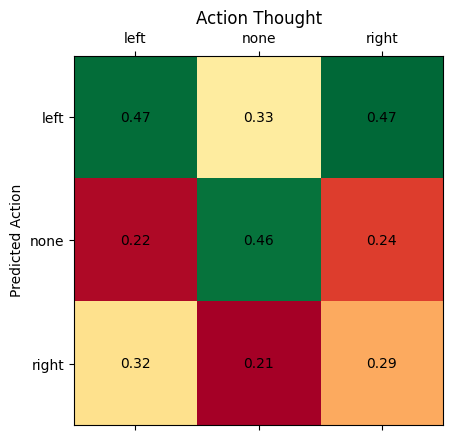

In [30]:
make_conf_mat(left_argmax_pct_dict, none_argmax_pct_dict, right_argmax_pct_dict)

Augmentation


61 acc


In [31]:
# import numpy as np
# import os
# from scipy.ndimage import shift
# import shutil
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/gdrive')

# # Function to augment EEG data
# def augment_eeg_data(eeg_data, time_shift_range=50, max_noise=0.1):
#     augmented_data = []

#     for signal in eeg_data:
#         num_channels, num_time_steps = signal.shape
#         augmented_signal = np.empty_like(signal)

#         # Loop through channels
#         for channel in range(num_channels):
#             # Time Shifting
#             time_shift = np.random.randint(-time_shift_range, time_shift_range)
#             if time_shift >= 0:
#                 shifted_signal = np.concatenate((signal[channel, time_shift:], np.zeros(time_shift)))
#             else:
#                 shifted_signal = np.concatenate((np.zeros(-time_shift), signal[channel, :num_time_steps + time_shift]))

#             # Random Noise Addition
#             noise = np.random.normal(scale=max_noise, size=num_time_steps)
#             augmented_channel = np.clip(shifted_signal + noise, -1, 1)

#             augmented_signal[channel, :] = augmented_channel

#         augmented_data.append(augmented_signal)

#     return np.array(augmented_data)

# # Load EEG signals from the source directory in Google Drive
# source_directory = '/content/gdrive/MyDrive/model_data/data/none'
# target_directory = '/content/gdrive/MyDrive/model_data/aug_data/none'

# if not os.path.exists(target_directory):
#     os.makedirs(target_directory)

# file_list = os.listdir(source_directory)

# for filename in file_list:
#     if filename.endswith('.npy'):
#         # Load the EEG signals from the .npy file
#         file_path = os.path.join(source_directory, filename)
#         eeg_signals = np.load(file_path)

#         # Perform data augmentation
#         augmented_signals = augment_eeg_data(eeg_signals)

#         # Save the augmented data to the target directory
#         target_file_path = os.path.join(target_directory, f"augmented_{filename}")
#         np.save(target_file_path, augmented_signals)

# print("Data augmentation completed, and augmented data saved to the target directory.")

.npy to .jpg

In [32]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt

# # Input directory containing .npy files
# input_directory = '/content/gdrive/MyDrive/model_data/validation_data/left'

# # Output directory to store the JPG files
# output_directory = '/content/gdrive/MyDrive/model_data/validation_data/left_jpg'

# # Create the output directory if it doesn't exist
# os.makedirs(output_directory, exist_ok=True)

# # List all .npy files in the input directory
# npy_files = [f for f in os.listdir(input_directory) if f.endswith('.npy')]

# # Loop through the .npy files and convert them to JPG
# for npy_file in npy_files:
#     # Load the numpy data
#     d = np.load(os.path.join(input_directory, npy_file))

#     # Plot the data
#     for channel in d[0]:
#         plt.plot(channel)

#     # Save the image as a JPG in the output directory
#     jpg_filename = os.path.splitext(npy_file)[0] + '.jpg'
#     plt.savefig(os.path.join(output_directory, jpg_filename))

#     # Close the current plot to free up resources
#     plt.close()

# print("Conversion completed. JPG files are saved in:", output_directory)

In [33]:
# from keras.models import load_model  # TensorFlow is required for Keras to work
# from PIL import Image, ImageOps  # Install pillow instead of PIL
# import numpy as np

# # Disable scientific notation for clarity
# np.set_printoptions(suppress=True)

# # Load the model
# model = load_model("/content/keras_model.h5", compile=False)

# # Load the labels
# class_names = open("/content/labels.txt", "r").readlines()

# # Create the array of the right shape to feed into the keras model
# # The 'length' or number of images you can put into the array is
# # determined by the first position in the shape tuple, in this case 1
# data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# # Replace this with the path to your image
# image = Image.open("/content/gdrive/MyDrive/model_data/validation_data/test/right_jpg/1573516751.jpg").convert("RGB")

# # resizing the image to be at least 224x224 and then cropping from the center
# size = (224, 224)
# image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# # turn the image into a numpy array
# image_array = np.asarray(image)

# # Normalize the image
# normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# # Load the image into the array
# data[0] = normalized_image_array

# # Predicts the model
# prediction = model.predict(data)
# index = np.argmax(prediction)
# class_name = class_names[index]
# confidence_score = prediction[0][index]

# # Print prediction and confidence score
# print("Class:", class_name[2:], end="")
# print("Confidence Score:", confidence_score)